# Model

In [1]:
import numpy as np
import torch
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

output_dim = 2
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)  # pretrained model
model.fc = torch.nn.Linear(512, output_dim)  # modify fully connected layer since ResNet output dimension is 1000

model = model.to(device)

# Dataset

In [3]:
from pathlib import Path
import torchvision.transforms as transforms
from src.dataset.xy_dataset import XYDataset

TASK = 'steering'
subdirectory = '2024-11-13'
path_to_dataset_directory = Path("../data") / TASK / subdirectory

TRANSFORMS = transforms.Compose([
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = XYDataset(path_to_dataset_directory, TRANSFORMS, random_hflip=False)

# Training

In [81]:
BATCH_SIZE = 8
EPOCHS = 10
LR = 1e-3

optimizer = torch.optim.Adam(model.parameters())

data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    num_batches = len(data_loader)
    
    for i, (images, xy) in enumerate(data_loader):
        images, xy = images.to(device), xy.to(device)
        
        model.train()
        outputs = model(images)
        
        loss = torch.mean((outputs - xy) ** 2)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if i > 0 and i % 10 == 0:
            print(f'Epoch {epoch}, Batch {i}, loss {loss.item():.4f}')

Epoch 0, Batch 10, loss 0.0954
Epoch 0, Batch 20, loss 0.0653
Epoch 0, Batch 30, loss 0.1044
Epoch 1, Batch 10, loss 0.0260
Epoch 1, Batch 20, loss 0.1281
Epoch 1, Batch 30, loss 0.0311
Epoch 2, Batch 10, loss 0.0299
Epoch 2, Batch 20, loss 0.0477
Epoch 2, Batch 30, loss 0.1181
Epoch 3, Batch 10, loss 0.0868
Epoch 3, Batch 20, loss 0.0396
Epoch 3, Batch 30, loss 0.0646
Epoch 4, Batch 10, loss 0.0282
Epoch 4, Batch 20, loss 0.0134
Epoch 4, Batch 30, loss 0.0760
Epoch 5, Batch 10, loss 0.0412
Epoch 5, Batch 20, loss 0.0770
Epoch 5, Batch 30, loss 0.1301
Epoch 6, Batch 10, loss 0.0121
Epoch 6, Batch 20, loss 0.0099
Epoch 6, Batch 30, loss 0.0128
Epoch 7, Batch 10, loss 0.0292
Epoch 7, Batch 20, loss 0.0126
Epoch 7, Batch 30, loss 0.0226
Epoch 8, Batch 10, loss 0.0106
Epoch 8, Batch 20, loss 0.0360
Epoch 8, Batch 30, loss 0.0316
Epoch 9, Batch 10, loss 0.0133
Epoch 9, Batch 20, loss 0.0234
Epoch 9, Batch 30, loss 0.0260


In [9]:
torch.save(model.state_dict(), '../models/10-02-24-steering.pth')

In [10]:
!ls ../models

10-02-24-steering.pth


# Load model

In [4]:
import torch
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'
output_dim = 2

In [5]:
path_to_steering_model = '../models/10-02-24-steering.pth'
model1 = torchvision.models.resnet18(weights=None)
model1.fc = torch.nn.Linear(512, output_dim)
model1 = model1.to(device).half()

In [6]:
model1.load_state_dict(torch.load(path_to_steering_model))

<All keys matched successfully>

# Saliency maps

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Prepare images

In [8]:
# without ColorJitter as it applies random changes to colors
TRANSFORMS2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
def get_image(idx):
    dataset.transform = TRANSFORMS2
    image_tensor, xy = dataset.__getitem__(idx)
    image_np = image_tensor.permute(1, 2, 0).numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    image_cv2 = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    return image_cv2

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

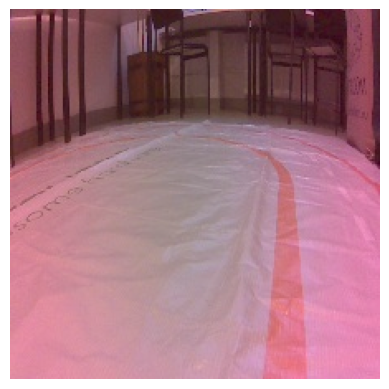

In [10]:
image0 = get_image(0)
plt.imshow(image0)
plt.axis('off')

### plot prediction

In [43]:
def plot_prediction_from_image(model, idx):
    image, xy = dataset.__getitem__(idx)

    model.eval()

    with torch.inference_mode():
        output = model(image.unsqueeze(dim=0).half()).detach().numpy().flatten()

        x = output[0]
        y = output[1]

        x = np.clip(int(224 * (x / 2.0 + 0.5)), 0, 224)
        y = np.clip(int(224 * (y / 2.0 + 0.5)), 0, 224)

    prediction = get_image(idx)
    prediction = cv2.circle(prediction, (x, y), 10, (1., 0., 0.), 3)

    plt.imshow(prediction)
    plt.axis('off')

224 205


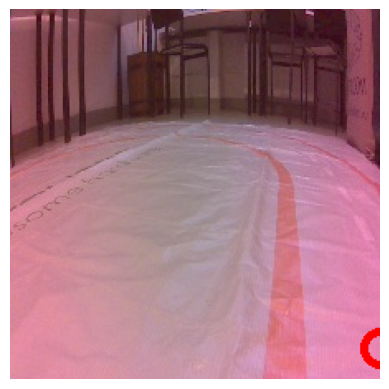

In [44]:
plot_prediction_from_image(model1, 1)

### get saliency maps

In [59]:
def get_saliency(model, idx):
    image, xy = dataset.__getitem__(idx)
    image = image.unsqueeze(dim=0).half()

    # we need to find the gradient with respect to the input image
    image.requires_grad = True

    # forward pass
    model.eval()
    output = model(image)
    x = output[:, 0]

    x.backward()

    saliency, _ = torch.max(image.grad.data.abs(),dim=1)

    return saliency[0]

In [60]:
s1 = get_saliency(model1, 1)

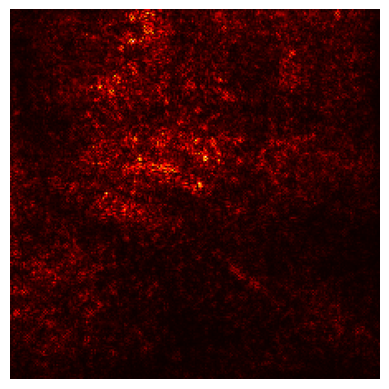

In [61]:
plt.imshow(s1, cmap=plt.cm.hot)
plt.axis('off')
plt.show()

In [64]:
def plot_image_with_saliency_map(model, idx):

    image = get_image(idx)
    saliency_map = get_saliency(model, idx)

    # saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(image, alpha=0.5)
    ax[1].imshow(saliency_map, cmap=plt.cm.hot, alpha=0.5)
    ax[1].set_title("Saliency Map Overlay")
    ax[1].axis("off")

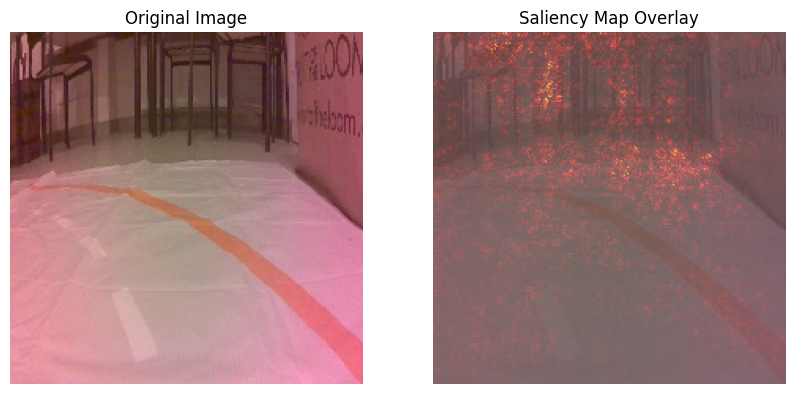

In [67]:
plot_image_with_saliency_map(model1, 2)

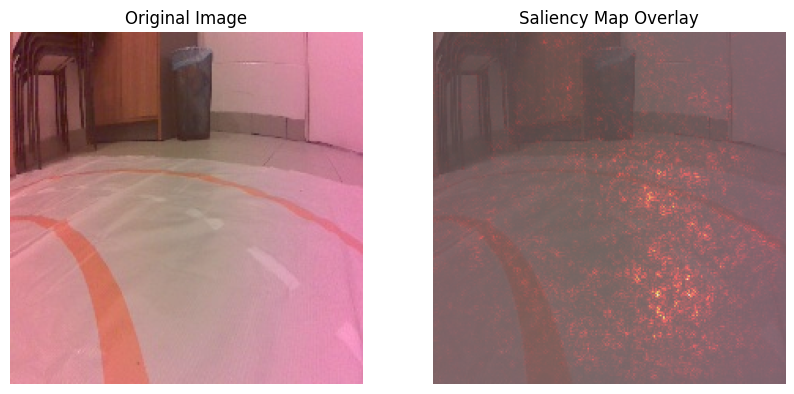

In [69]:
plot_image_with_saliency_map(model1, 3)

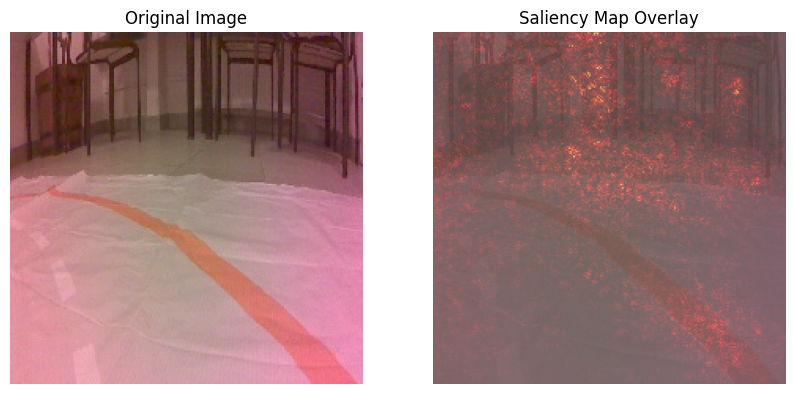

In [71]:
plot_image_with_saliency_map(model1, 4)